# 1

## Аналитическое решение задачи регрессии в векторной форме
$\boldsymbol{w} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}$

## Функция потерь с регуляризацией
$\min_w \left( \sum_{i=1}^n L(f(x_i, w), y_i) + \lambda R(w) \right)$

Регуляризация L1 добавляет штраф
$R(w) = \|w\|_1 = \sum_{i=1}^d |w_i|$
Поскольку каждый ненулевой коэффициент увеличивает штрафную функцию, слабые
признаки должны иметь нулевые коэффициенты. Таким образом, регуляризация L1
приводит к разреженным решениям и может использоваться для выбора признаков.

Для подбора нелинейных зависимостей следует использовать нелинейные подходы для
функций, экспонента, логорифм, полиномиальные функции и др

In [222]:
import pandas as pd
import numpy as np
import random
##import lightgbm as lgb
import scipy
##import statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error, mean_squared_error
from collections import Counter

In [223]:
data = pd.read_json('datasets/train.json')
data.info()
display()

<class 'pandas.core.frame.DataFrame'>
Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [224]:
data['interest_level'] = data['interest_level'].replace({'low':0,'medium':1,'high':2})

In [225]:
data['interest_level'].value_counts()

interest_level
0    34284
1    11229
2     3839
Name: count, dtype: int64

In [226]:
data.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,1
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,0
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,1
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,1
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,0


In [227]:
def clean(feature):
  if feature is None:
    return []
  feature_str = str(feature)
  if feature_str.strip() == '[]':
    return []
  cleaned = (feature_str.replace('[', '').replace(']', '').replace("'", "").replace('"', '').strip())
  return [item.strip() for item in cleaned.split(',') if item.strip()]

data['features'] = data['features'].apply(clean)


all_features = []
for feature_list in data['features']:
    all_features.extend(feature_list)

In [228]:
top = Counter(all_features).most_common(20)
top

[('Elevator', 25915),
 ('Cats Allowed', 23540),
 ('Hardwood Floors', 23527),
 ('Dogs Allowed', 22035),
 ('Doorman', 20898),
 ('Dishwasher', 20426),
 ('No Fee', 18062),
 ('Laundry in Building', 16344),
 ('Fitness Center', 13252),
 ('Pre-War', 9148),
 ('Laundry in Unit', 8738),
 ('Roof Deck', 6542),
 ('Outdoor Space', 5268),
 ('Dining Room', 5136),
 ('High Speed Internet', 4299),
 ('Balcony', 2992),
 ('Swimming Pool', 2730),
 ('Laundry In Building', 2593),
 ('New Construction', 2559),
 ('Terrace', 2283)]

In [229]:

for item in top:
  data[f'{item[0]}'] = data['features'].apply(lambda x: int(item[0] in str(x)) if item else 0)
print(data)

        bathrooms  bedrooms                       building_id  \
4             1.0         1  8579a0b0d54db803821a35a4a615e97a   
6             1.0         2  b8e75fc949a6cd8225b455648a951712   
9             1.0         2  cd759a988b8f23924b5a2058d5ab2b49   
10            1.5         3  53a5b119ba8f7b61d4e010512e0dfc85   
15            1.0         0  bfb9405149bfff42a92980b594c28234   
...           ...       ...                               ...   
124000        1.0         3  92bbbf38baadfde0576fc496bd41749c   
124002        1.0         2  5565db9b7cba3603834c4aa6f2950960   
124004        1.0         1  67997a128056ee1ed7d046bbb856e3c7   
124008        1.0         2  3c0574a740154806c18bdf1fddd3d966   
124009        1.0         3  d89f514c3ed0abaae52cba7017ac0701   

                    created  \
4       2016-06-16 05:55:27   
6       2016-06-01 05:44:33   
9       2016-06-14 15:19:59   
10      2016-06-24 07:54:24   
15      2016-06-28 03:50:23   
...                     ...   
12

In [230]:
features_22 = ['bathrooms','bedrooms']
for item in top:
  features_22.append(item[0])
features_22

['bathrooms',
 'bedrooms',
 'Elevator',
 'Cats Allowed',
 'Hardwood Floors',
 'Dogs Allowed',
 'Doorman',
 'Dishwasher',
 'No Fee',
 'Laundry in Building',
 'Fitness Center',
 'Pre-War',
 'Laundry in Unit',
 'Roof Deck',
 'Outdoor Space',
 'Dining Room',
 'High Speed Internet',
 'Balcony',
 'Swimming Pool',
 'Laundry In Building',
 'New Construction',
 'Terrace']

## Линейная регрессия

In [231]:
np.random.seed(21)

In [232]:
class LinRegSGD:
  def __init__(self, learning_rate=0.01, iters=1000):
    self.learning_rate = learning_rate
    self.iters = iters
    self.weights = None
    self.bias = None
  def fit(self, X, y):
    np.random.seed(21)
    X = X.to_numpy()
    y = y.to_numpy()
    n_samples, n_features = X.shape
    self.weights = np.zeros(n_features)
    self.bias = 0

    for iter in range(self.iters):
      for i in range(n_samples):
        xi = X[i]
        yi = y[i]

        y_pred = np.dot(xi, self.weights) + self.bias
        error = y_pred - yi
        self.weights -= self.learning_rate * error * xi
        self.bias -= self.learning_rate * error

  def predict(self, X):
        return np.dot(X, self.weights) + self.bias

In [233]:
cleaned = data.loc[:, features_22 + ['price']]
cleaned.reset_index(inplace=True, drop=True)
cleaned

,bathrooms,bedrooms,Elevator,Cats Allowed,Hardwood Floors,Dogs Allowed,Doorman,Dishwasher,No Fee,Laundry in Building,...,Roof Deck,Outdoor Space,Dining Room,High Speed Internet,Balcony,Swimming Pool,Laundry In Building,New Construction,Terrace,price
0,1.0,1,0,1,1,1,0,1,0,1,...,0,0,1,0,0,0,0,0,0,2400
1,1.0,2,1,0,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,3800
2,1.0,2,1,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,3495
3,1.5,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3000
4,1.0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,2795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49347,1.0,3,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2800
49348,1.0,2,1,1,0,1,1,0,1,0,...,0,1,0,0,0,0,1,0,0,2395
49349,1.0,1,1,1,1,1,0,1,1,1,...,0,0,1,0,0,0,0,0,0,1850
49350,1.0,2,0,0,0,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,4195


[]

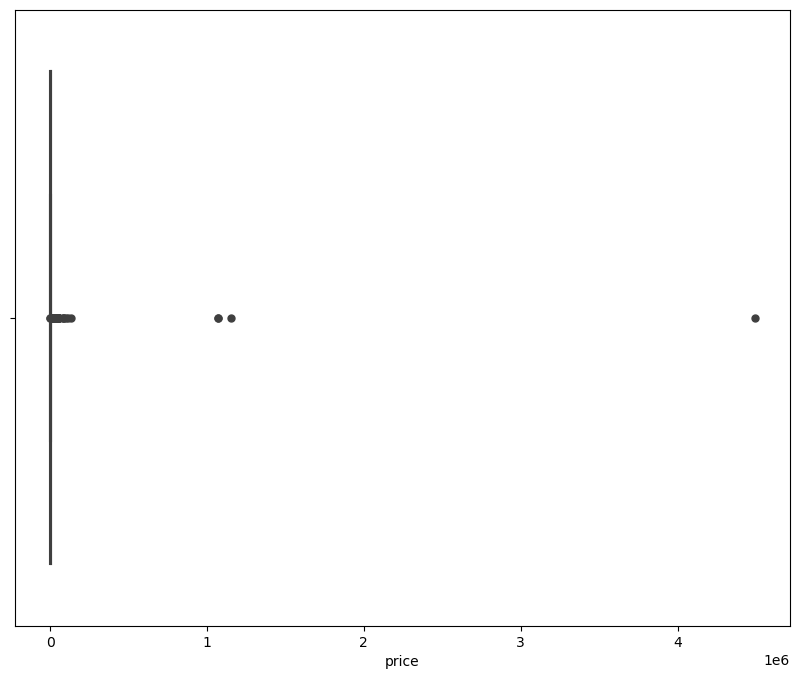

In [234]:
plt.figure(figsize=(10,8))
sns.boxplot(x=cleaned['price'], flierprops={'marker': 'o', })
plt.plot()

In [235]:
low = cleaned['price'].quantile(0.01)
up = cleaned['price'].quantile(0.99)
cleaned = cleaned[(cleaned['price'] > low) & (cleaned['price'] < up)].copy()

In [236]:
X = cleaned.drop(columns=['price'])
y = cleaned['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [16]:
result_MAE = pd.DataFrame(columns=['model', 'train', 'test'])
result_RMSE = pd.DataFrame(columns=['model', 'train', 'test'])
result_R2 = pd.DataFrame(columns=['model', 'train', 'test'])
def r2_score(y_true, y_pred):
  y_true = y_true.to_numpy()
  return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))


In [17]:
def evaluate(model, name, X_train, y_train, X_test, y_test, result_MAE, result_RMSE, result_R2):

  model.fit(X_train, y_train)
  y_trpred = model.predict(X_train)
  y_pred = model.predict(X_test)

  train_mae = mean_absolute_error(y_train, y_trpred)
  train_rmse = np.sqrt(mean_squared_error(y_train, y_trpred))
  train_r2 = r2_score(y_train, y_trpred)
  test_mae = round(mean_absolute_error(y_test, y_pred),4)
  test_rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),4)
  test_r2 = round(r2_score(y_test, y_pred),4)
  result_MAE = pd.concat([
    result_MAE,pd.DataFrame({
    'model': [name],
    'train': [train_mae],
    'test': [test_mae]})
    ], ignore_index=True)
  result_RMSE = pd.concat([
    result_RMSE,pd.DataFrame({
    'model': [name],
    'train': [train_rmse],
    'test': [test_rmse]})
    ], ignore_index=True)
  result_R2 = pd.concat([
    result_R2,pd.DataFrame({
    'model': [name],
    'train': [train_r2],
    'test': [test_r2]})
    ], ignore_index=True)
  return result_MAE, result_RMSE, result_R2

In [18]:
msgd = LinRegSGD()
result_MAE, result_RMSE, result_R2 = evaluate(msgd, 'my_linreg', X_train, y_train, X_test, y_test, result_MAE, result_RMSE, result_R2)
result_R2

,model,train,test
0,my_linreg,0.558099,0.5754


In [19]:
linreg = LinearRegression()
result_MAE, result_RMSE, result_R2 = evaluate(linreg, 'sk_linreg', X_train, y_train, X_test, y_test, result_MAE, result_RMSE, result_R2)

In [20]:
result_R2

,model,train,test
0,my_linreg,0.558099,0.5754
1,sk_linreg,0.576729,0.5935




## Ridge lasso Elastic

In [21]:
class RegularizedLinearRegression:
  def __init__(self, alpha=1.0, reg_type='l1', l1_ratio=0.5, learning_rate=0.01, iters=1000):
    ## l1 - lasso, l2 - ridge, elasticnet - elasticNet
    self.alpha = alpha
    self.reg_type = reg_type
    self.l1_ratio = l1_ratio
    self.learning_rate = learning_rate
    self.iters = iters
    self.weights = None
    self.bias = None
  def regularization(self, weights):
    if self.regularization == 'l2':
      return 2 * self.alpha * weights
    elif self.regularization == 'l1':
      return self.alpha * np.sign(weights)
    elif self.regularization == 'elasticnet':
      return self.alpha * (self.l1_ratio * np.sign(weights) + (1 - self.l1_ratio) * 2 * weights)
    else:
      return 0

  def fit(self, X, y):
    np.random.seed(21)
    X = X.to_numpy()
    y = y.to_numpy()
    n_samples, n_features = X.shape
    self.weights = np.zeros(n_features)
    self.bias = 0

    for iter in range(self.iters):
      for i in range(n_samples):
        xi = X[i]
        yi = y[i]

        y_pred = np.dot(xi, self.weights) + self.bias
        error = y_pred - yi
        self.weights -= self.learning_rate * (error * xi + self.regularization(self.weights))
        self.bias -= self.learning_rate * error

  def predict(self, X):
    return np.dot(X, self.weights) + self.bias

In [22]:
mridge = RegularizedLinearRegression(reg_type='l2')
result_MAE, result_RMSE, result_R2 = evaluate(mridge, 'my_ridge', X_train, y_train, X_test, y_test, result_MAE, result_RMSE, result_R2)
ridge = Ridge()
result_MAE, result_RMSE, result_R2 = evaluate(ridge, 'sk_ridge', X_train, y_train, X_test, y_test, result_MAE, result_RMSE, result_R2)

In [23]:
mlasso = RegularizedLinearRegression(reg_type='l1')
result_MAE, result_RMSE, result_R2 = evaluate(mlasso, 'my_lasso', X_train, y_train, X_test, y_test, result_MAE, result_RMSE, result_R2)
lasso = Lasso()
result_MAE, result_RMSE, result_R2 = evaluate(lasso, 'sk_lasso', X_train, y_train, X_test, y_test, result_MAE, result_RMSE, result_R2)

In [24]:
mel = RegularizedLinearRegression(reg_type='elasticnet')
result_MAE, result_RMSE, result_R2 = evaluate(mel, 'my_elastic', X_train, y_train, X_test, y_test, result_MAE, result_RMSE, result_R2)
el = ElasticNet(alpha = 0.1)
result_MAE, result_RMSE, result_R2 = evaluate(el, 'sk_elastic', X_train, y_train, X_test, y_test, result_MAE, result_RMSE, result_R2)

In [25]:
display(result_MAE)
display(result_RMSE)
display(result_R2)

,model,train,test
0,my_linreg,704.923451,706.9318
1,sk_linreg,708.419581,709.5424
2,my_ridge,704.923451,706.9318
3,sk_ridge,708.416149,709.5410
4,my_lasso,704.923451,706.9318
5,sk_lasso,707.997765,709.3678
6,my_elastic,704.923451,706.9318
7,sk_elastic,713.576948,716.6460


,model,train,test
0,my_linreg,1050.621805,1046.4821
1,sk_linreg,1028.236443,1023.9244
2,my_ridge,1050.621805,1046.4821
3,sk_ridge,1028.236450,1023.9277
4,my_lasso,1050.621805,1046.4821
5,sk_lasso,1028.417595,1024.2864
6,my_elastic,1050.621805,1046.4821
7,sk_elastic,1042.020105,1042.6124


,model,train,test
0,my_linreg,0.558099,0.5754
1,sk_linreg,0.576729,0.5935
2,my_ridge,0.558099,0.5754
3,sk_ridge,0.576729,0.5935
4,my_lasso,0.558099,0.5754
5,sk_lasso,0.576580,0.5932
6,my_elastic,0.558099,0.5754
7,sk_elastic,0.565305,0.5786


## Нормализация

### MinMaxScaler

#### Нужна

Регуляризованные модели
Штрафные коэффициенты (alpha) применяются ко всем весам одинаково.
Без нормализации признаки с большим масштабом будут неоправданно сильнее штрафоваться.

Методы ближайших соседей и другии на расстоянии
Алгоритмы рассчитывают расстояния между точками, признаки в разных масштабах исказят расстояния.

#### Не нужна

деревья решений не зависят от масштаба
фиксированные признаки не требуют нормализации

формула x_norm = (x-min)/(max-min)

#### Код

In [26]:
class MyMinMaxScaler:
  def __init__(self):
    self.df_min = None
    self.df_max = None

  def fit(self, X):
    X = np.asarray(X)
    self.df_min = np.min(X, axis=0)
    self.df_max = np.max(X, axis=0)
    return self

  def transform(self, X):
    X = np.asarray(X)
    return (X - self.df_min)/(self.df_max - self.df_min + np.finfo(float).eps)

  def fit_transform(self, X):
    return self.fit(X).transform(X)


In [27]:
mysc = MyMinMaxScaler()
my_X_train = pd.DataFrame(mysc.fit_transform(X_train))
my_X_test = pd.DataFrame(mysc.transform(X_test))
display(my_X_train)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.10,0.125,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.10,0.125,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.10,0.250,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.20,0.250,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.10,0.250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38669,0.10,0.375,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38670,0.25,0.500,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38671,0.10,0.250,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38672,0.10,0.125,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
sc = MinMaxScaler()
sk_X_train = pd.DataFrame(sc.fit_transform(X_train))
sk_X_test = pd.DataFrame(sc.transform(X_test))
display(sk_X_train)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.10,0.125,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.10,0.125,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.10,0.250,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.20,0.250,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.10,0.250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38669,0.10,0.375,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38670,0.25,0.500,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38671,0.10,0.250,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38672,0.10,0.125,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
np.allclose(my_X_train, sk_X_train)

True

In [30]:
np.allclose(my_X_test, sk_X_test)

True

Результаты идентичны

### StandartScaler

#### Нужна

в тех же случаях что и минмакс в регуляции и расстоянии, градиентном спуске для данных с нормальным распределением

#### Не нужна

для категориальных признаков и данных с выбросами

#### Код

In [31]:
class MyStandardScaler:
  def __init__(self):
    self.df_mean = None
    self.df_scale = None

  def fit(self, X):
    X = np.asarray(X)
    self.df_mean = np.mean(X, axis=0)
    self.df_scale = np.std(X, axis=0)
    self.df_scale[self.df_scale == 0] = 1.0
    return self

  def transform(self, X):
    X = np.asarray(X)
    return (X - self.df_mean)/(self.df_scale)

  def fit_transform(self, X):
    return self.fit(X).transform(X)


In [32]:
mysc = MyStandardScaler()
mys_X_train = pd.DataFrame(mysc.fit_transform(X_train))
mys_X_test = pd.DataFrame(mysc.transform(X_test))
display(my_X_train)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.10,0.125,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.10,0.125,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.10,0.250,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.20,0.250,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.10,0.250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38669,0.10,0.375,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38670,0.25,0.500,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38671,0.10,0.250,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38672,0.10,0.125,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
sc = StandardScaler()
ssk_X_train = pd.DataFrame(sc.fit_transform(X_train))
ssk_X_test = pd.DataFrame(sc.transform(X_test))
display(sk_X_train)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.10,0.125,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.10,0.125,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.10,0.250,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.20,0.250,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.10,0.250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38669,0.10,0.375,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38670,0.25,0.500,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38671,0.10,0.250,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38672,0.10,0.125,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
np.allclose(mys_X_train, ssk_X_train)

True

In [35]:
np.allclose(mys_X_test, ssk_X_test)

True

Результаты идентичны

### Fiting

In [36]:
result_MAE, result_RMSE, result_R2 = evaluate(linreg, 'minmax_sk_linreg', sk_X_train, y_train, sk_X_test, y_test, result_MAE, result_RMSE, result_R2)
result_MAE, result_RMSE, result_R2 = evaluate(linreg, 'stdscaler_sk_linreg', ssk_X_train, y_train, ssk_X_test, y_test, result_MAE, result_RMSE, result_R2)

In [37]:
result_MAE

,model,train,test
0,my_linreg,704.923451,706.9318
1,sk_linreg,708.419581,709.5424
2,my_ridge,704.923451,706.9318
3,sk_ridge,708.416149,709.5410
4,my_lasso,704.923451,706.9318
5,sk_lasso,707.997765,709.3678
6,my_elastic,704.923451,706.9318
7,sk_elastic,713.576948,716.6460
8,minmax_sk_linreg,708.419581,709.5424
9,stdscaler_sk_linreg,708.419581,709.5424


In [38]:
result_MAE, result_RMSE, result_R2 = evaluate(ridge, 'minmax_ridge', sk_X_train, y_train, sk_X_test, y_test, result_MAE, result_RMSE, result_R2)
result_MAE, result_RMSE, result_R2 = evaluate(ridge, 'stdscaler_ridge', ssk_X_train, y_train, ssk_X_test, y_test, result_MAE, result_RMSE, result_R2)

In [39]:
result_MAE, result_RMSE, result_R2 = evaluate(lasso, 'minmax_lasso', sk_X_train, y_train, sk_X_test, y_test, result_MAE, result_RMSE, result_R2)
result_MAE, result_RMSE, result_R2 = evaluate(lasso, 'stdscaler_lasso', ssk_X_train, y_train, ssk_X_test, y_test, result_MAE, result_RMSE, result_R2)

In [40]:
result_MAE, result_RMSE, result_R2 = evaluate(el, 'minmax_elastic', sk_X_train, y_train, sk_X_test, y_test, result_MAE, result_RMSE, result_R2)
result_MAE, result_RMSE, result_R2 = evaluate(el, 'stdscaler_elastic', ssk_X_train, y_train, ssk_X_test, y_test, result_MAE, result_RMSE, result_R2)

In [41]:
display(result_MAE)
display(result_RMSE)
display(result_R2)

,model,train,test
0,my_linreg,704.923451,706.9318
1,sk_linreg,708.419581,709.5424
2,my_ridge,704.923451,706.9318
3,sk_ridge,708.416149,709.5410
4,my_lasso,704.923451,706.9318
5,sk_lasso,707.997765,709.3678
6,my_elastic,704.923451,706.9318
7,sk_elastic,713.576948,716.6460
8,minmax_sk_linreg,708.419581,709.5424
9,stdscaler_sk_linreg,708.419581,709.5424


,model,train,test
0,my_linreg,1050.621805,1046.4821
1,sk_linreg,1028.236443,1023.9244
2,my_ridge,1050.621805,1046.4821
3,sk_ridge,1028.236450,1023.9277
4,my_lasso,1050.621805,1046.4821
5,sk_lasso,1028.417595,1024.2864
6,my_elastic,1050.621805,1046.4821
7,sk_elastic,1042.020105,1042.6124
8,minmax_sk_linreg,1028.236443,1023.9244
9,stdscaler_sk_linreg,1028.236443,1023.9244


,model,train,test
0,my_linreg,0.558099,0.5754
1,sk_linreg,0.576729,0.5935
2,my_ridge,0.558099,0.5754
3,sk_ridge,0.576729,0.5935
4,my_lasso,0.558099,0.5754
5,sk_lasso,0.576580,0.5932
6,my_elastic,0.558099,0.5754
7,sk_elastic,0.565305,0.5786
8,minmax_sk_linreg,0.576729,0.5935
9,stdscaler_sk_linreg,0.576729,0.5935


## Overfit

In [42]:
X = data[['bathrooms','bedrooms','interest_level']]
y = data['price']

In [43]:
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X, y, test_size=0.2, random_state=21)

In [44]:
poly = PolynomialFeatures(degree=10)
X_train_poly = poly.fit_transform(X_train_poly)
X_test_poly = poly.fit_transform(X_test_poly)

In [45]:
result_MAE, result_RMSE, result_R2 = evaluate(linreg, 'poly_linreg', X_train_poly, y_train_poly, X_test_poly, y_test_poly, result_MAE, result_RMSE, result_R2)
result_MAE, result_RMSE, result_R2 = evaluate(ridge, 'poly_ridge', X_train_poly, y_train_poly, X_test_poly, y_test_poly, result_MAE, result_RMSE, result_R2)
result_MAE, result_RMSE, result_R2 = evaluate(lasso, 'poly_lasso', X_train_poly, y_train_poly, X_test_poly, y_test_poly, result_MAE, result_RMSE, result_R2)
result_MAE, result_RMSE, result_R2 = evaluate(el, 'poly_elastic', X_train_poly, y_train_poly, X_test_poly, y_test_poly, result_MAE, result_RMSE, result_R2)

C:\Users\ivanl\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.134e+13, tolerance: 2.280e+09
  model = cd_fast.enet_coordinate_descent(
C:\Users\ivanl\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.134e+13, tolerance: 2.280e+09
  model = cd_fast.enet_coordinate_descent(


In [46]:
display(result_MAE, result_RMSE, result_R2)

,model,train,test
0,my_linreg,704.923451,706.9318
1,sk_linreg,708.419581,709.5424
2,my_ridge,704.923451,706.9318
3,sk_ridge,708.416149,709.5410
4,my_lasso,704.923451,706.9318
5,sk_lasso,707.997765,709.3678
6,my_elastic,704.923451,706.9318
7,sk_elastic,713.576948,716.6460
8,minmax_sk_linreg,708.419581,709.5424
9,stdscaler_sk_linreg,708.419581,709.5424


,model,train,test
0,my_linreg,1050.621805,1046.4821
1,sk_linreg,1028.236443,1023.9244
2,my_ridge,1050.621805,1046.4821
3,sk_ridge,1028.236450,1023.9277
4,my_lasso,1050.621805,1046.4821
5,sk_lasso,1028.417595,1024.2864
6,my_elastic,1050.621805,1046.4821
7,sk_elastic,1042.020105,1042.6124
8,minmax_sk_linreg,1028.236443,1023.9244
9,stdscaler_sk_linreg,1028.236443,1023.9244


,model,train,test
0,my_linreg,0.558099,0.5754
1,sk_linreg,0.576729,0.5935
2,my_ridge,0.558099,0.5754
3,sk_ridge,0.576729,0.5935
4,my_lasso,0.558099,0.5754
5,sk_lasso,0.576580,0.5932
6,my_elastic,0.558099,0.5754
7,sk_elastic,0.565305,0.5786
8,minmax_sk_linreg,0.576729,0.5935
9,stdscaler_sk_linreg,0.576729,0.5935


ridge and linear 

### Naive models

In [47]:
mean = y_train.mean()
y_trpred = np.full_like(y_train, mean)
y_pred = np.full_like(y_test, mean)
train_mae = mean_absolute_error(y_train, y_trpred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_trpred))
train_r2 = r2_score(y_train, y_trpred)
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)
result_MAE = pd.concat([
    result_MAE,pd.DataFrame({
    'model': ['mean'],
    'train': [train_mae],
    'test': [test_mae]})
    ], ignore_index=True)
result_RMSE = pd.concat([
    result_RMSE,pd.DataFrame({
    'model': ['mean'],
    'train': [train_rmse],
    'test': [test_rmse]})
    ], ignore_index=True)
result_R2 = pd.concat([
    result_R2,pd.DataFrame({
    'model': ['mean'],
    'train': [train_r2],
    'test': [test_r2]})
    ], ignore_index=True)

In [48]:
median = y_train.median()
y_trpred = np.full_like(y_train, median)
y_pred = np.full_like(y_test, median)
train_mae = mean_absolute_error(y_train, y_trpred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_trpred))
train_r2 = r2_score(y_train, y_trpred)
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)
result_MAE = pd.concat([
    result_MAE,pd.DataFrame({
    'model': ['median'],
    'train': [train_mae],
    'test': [test_mae]})
    ], ignore_index=True)
result_RMSE = pd.concat([
    result_RMSE,pd.DataFrame({
    'model': ['median'],
    'train': [train_rmse],
    'test': [test_rmse]})
    ], ignore_index=True)
result_R2 = pd.concat([
    result_R2,pd.DataFrame({
    'model': ['median'],
    'train': [train_r2],
    'test': [test_r2]})
    ], ignore_index=True)

In [59]:
display(result_MAE, result_RMSE)

,model,train,test
0,my_linreg,704.923451,706.931800
1,sk_linreg,708.419581,709.542400
2,my_ridge,704.923451,706.931800
3,sk_ridge,708.416149,709.541000
4,my_lasso,704.923451,706.931800
5,sk_lasso,707.997765,709.367800
6,my_elastic,704.923451,706.931800
7,sk_elastic,713.576948,716.646000
8,minmax_sk_linreg,708.419581,709.542400
9,stdscaler_sk_linreg,708.419581,709.542400


,model,train,test
0,my_linreg,1050.621805,1046.482100
1,sk_linreg,1028.236443,1023.924400
2,my_ridge,1050.621805,1046.482100
3,sk_ridge,1028.236450,1023.927700
4,my_lasso,1050.621805,1046.482100
5,sk_lasso,1028.417595,1024.286400
6,my_elastic,1050.621805,1046.482100
7,sk_elastic,1042.020105,1042.612400
8,minmax_sk_linreg,1028.236443,1023.924400
9,stdscaler_sk_linreg,1028.236443,1023.924400


## Bonus

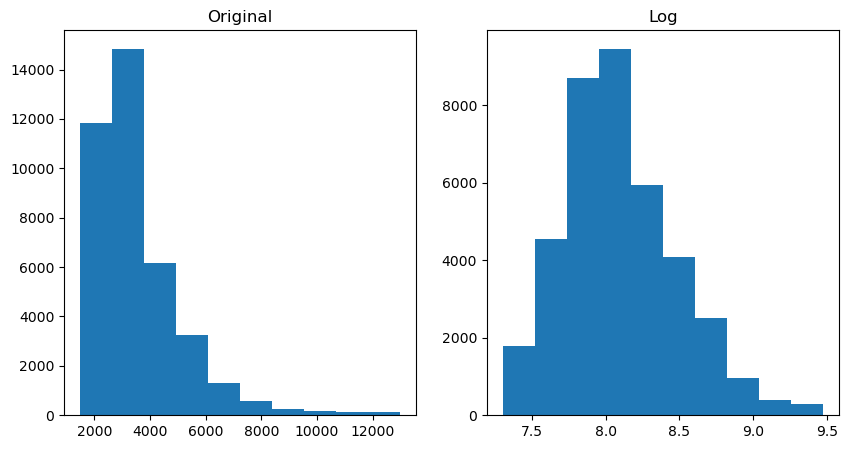

In [237]:
y_log_train = np.log1p(y_train)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(y_train)
plt.title('Original')

plt.subplot(1, 2, 2)
plt.hist(y_log_train)
plt.title('Log')
plt.show()

In [238]:
def bonus_log(model, X_train, X_test, y_train,y_test, y_log_train):
    model.fit(X_train, y_log_train)
    y_trpred = np.expm1(model.predict(X_train))
    y_pred = np.expm1(model.predict(X_test))
    print(f'train {r2_score(y_train, y_trpred):.1f}')
    print(f'test {r2_score(y_test, y_pred):.1f}')

In [239]:
ridge = Ridge()
bonus_log(ridge, X_train, X_test, y_train,y_test, y_log_train)

train 0.6
test 0.6


### Outliers

In [240]:
train_data = X_train.copy()
train_data['price'] = y_train
low = train_data['bathrooms'].quantile(0)
up = train_data['bathrooms'].quantile(0.99)
train_data = train_data[(train_data['bathrooms'] > low) & (train_data['bathrooms'] < up)]
new_X_train = train_data.drop('price', axis=1)
new_y_train = train_data['price']

In [241]:
el = Ridge()
el.fit(new_X_train, new_y_train)
y_trpred = el.predict(new_X_train)
y_pred = el.predict(X_test)
print(f'train {r2_score(new_y_train, y_trpred):.1f}')
print(f'test {r2_score(y_test, y_pred):.1f}')

train 0.5
test 0.6


### Analytic

In [242]:
class LinearRegressionAnalytical:
    def __init__(self):
        self.weights = None

    def fit(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        self.weights = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
        
    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b.dot(self.weights)

In [243]:
model = LinearRegressionAnalytical()
model.fit(X_train, y_train)
y_trpred = model.predict(X_train)
y_pred = model.predict(X_test)
print(f'train {r2_score(y_train, y_trpred):.1f}')
print(f'test {r2_score(y_test, y_pred):.1f}')

train 0.6
test 0.6


### Batch

In [244]:
class LinearRegressionBatch:
    def __init__(self, learning_rate=0.1, iters=1000):
        self.lr = learning_rate
        self.iters = iters
        self.weights = None

    def fit(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        n_samples, n_features = X_b.shape
        self.weights = np.zeros(n_features)
        for _ in range(self.iters):
            gradients = 2/n_samples * X_b.T.dot(X_b.dot(self.weights) - y)
            self.weights -= self.lr * gradients

    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b.dot(self.weights)

In [245]:
model = LinearRegressionBatch()
model.fit(X_train, y_train)
y_trpred = model.predict(X_train)
y_pred = model.predict(X_test)
print(f'train {r2_score(y_train, y_trpred):.1f}')
print(f'test {r2_score(y_test, y_pred):.1f}')

train 0.6
test 0.6
